/root/anaconda3/envs/lcxpy3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


jiaduobaoguan 0.9933072924613953
jiaduobaoguan 0.9794328212738037
quecaonatie 0.9788433313369751
quecaonatie 0.9779952168464661
lanfangyuancha 0.9763323068618774
lanfangyuancha 0.9662295579910278
jiaduobaoguan 0.9542271494865417
lvliangshengzhazhi 0.9536859393119812
quecaonatie 0.9424936175346375
lanfangyuancha 0.9379785060882568
jiaduobaoguan 0.9354867339134216
weitaningmengcha 0.9348646998405457
jiaduobaoguan 0.9188773036003113
lvliangshengzhazhi 0.9004462957382202
weitaningmengcha 0.888617217540741
weitaningmengcha 0.8789517283439636
lvliangshengzhazhi 0.864765465259552
jiaduobaoguan 0.8414293527603149


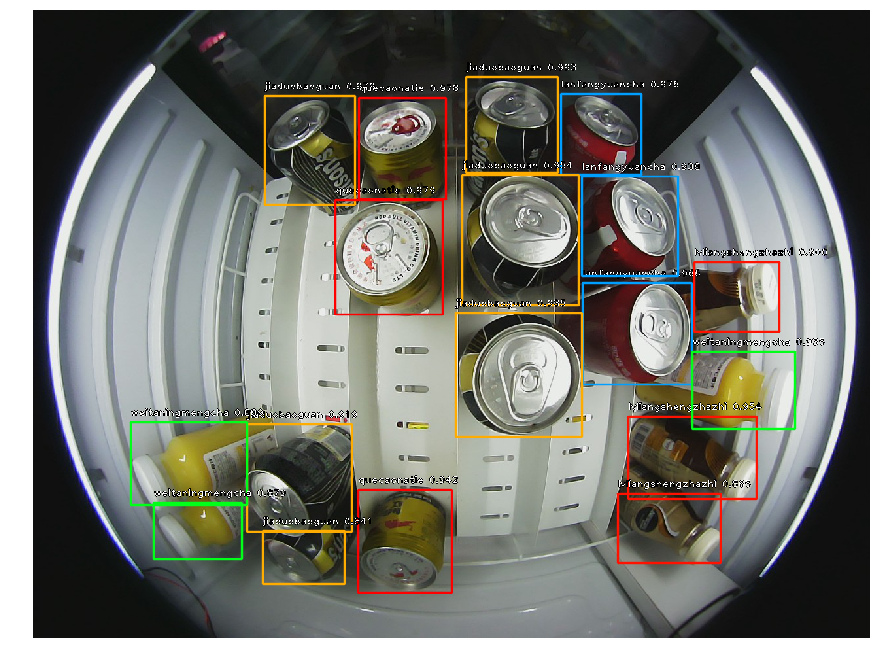

In [2]:
# -*- coding: utf-8 -*-
import keras
import sys
import xml.etree.ElementTree as ET
import operator
import shutil

sys.path.append("/home/lichunxue/Desktop/keras-retinanet/")
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import cv2
import os
import numpy as np
#from ai_site.src.api.utils import get_new_model

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
from matplotlib import pyplot as plt

def format_result(rclasses, rscores):
    dictionary = {}
    for idx, i in enumerate(rclasses):
        if dictionary.get(i):
            dictionary[i][0] = dictionary.get(i)[0] + 1
            dictionary[i][1].append(str(rscores[idx]))
        else:
            dictionary[i] = [1, []]
            dictionary[i][1].append(str(rscores[idx]))


    res = []
    for key, item in dictionary.items():
        res.append({"goods_name": labels_to_names.get(key), "goods_cnt": item[0], "goods_conf": item[1]})
    return res


labels_to_names = {0: 'balishui',\
                   1: 'lanfangyuancha',\
                   2: 'keleguan',\
                   3: 'lvliangshengzhazhi',\
                   4: 'quecaonatie',\
                   5: 'hongniu',\
                   6: 'weitaningmengcha',\
                   7: 'nongfuNFC',\
                   8: 'jiaduobaoguan',\
                   9: 'quchenshiyuanwei',\
                   10: 'beibingyangjuqi',\
                   11: 'maidongqingningkouwei',\
                   12: 'xingbakemokawei',\
                   13: 'meirishiliulvcha',\
                   14: 'xiangcaosuda',\
                   15: 'weikabingdimoka',\
                   16: 'kalabaoweishengsu',\
                   17: 'sanyuanchunnai',\
                   18: 'lingdukele',\
                   19: 'kangshifubinghongcha',
                   20:'changqingyanmaihuangtao',
                   21:'chunxiangyishengjun',
                   22:'guanzhuangweita',
                   23:'huorunmangguosuannai',
                   24:'huoxingrusuanyuanwei',
                   25:'meiniandachengwei',
                   26:'meiricchengzhi',
                   27:'moqitaozhiyinliao',
                   28:'qiandongyishenggulanmei', 
                   29:'qiulingewasi',
                   30:'qixibingshuangningmeng',
                   31:'ranchachunxiang',
                   32:'sandelicha',
                   33:'tianfangyetanbingfen',
                   34:'weikezixiangjiao',
                   35:'xiangpiaopiaoniurucha',
                   36:'xingbeichunnongyu',
                   37:'younuolanmeiguoli',
                   38:'yuanweidounaiweita',
                   39:'zhenzhenlizhiguowei',}

names_to_number1 = {'balishui': 0,\
                    'jiaduobaoguan': 0,\
                    'quchenshiyuanwei': 0,\
                    'weitaningmengcha': 0,\
                    'lanfangyuancha': 0,\
                    'keleguan': 0,\
                    'hongniu': 0,\
                    'beibingyangjuqi': 0,\
                    'quecaonatie': 0,\
                    'maidongqingningkouwei': 0,\
                    'lvliangshengzhazhi': 0,\
                    'xingbakemokawei': 0,\
                    'meirishiliulvcha': 0,\
                    'nongfuNFC': 0,\
                    'xiangcaosuda': 0,\
                    'weikabingdimoka': 0,\
                    'kalabaoweishengsu': 0,\
                    'sanyuanchunnai': 0,\
                    'lingdukele': 0,\
                    'kangshifubinghongcha': 0,}


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)


def init_dict():
    for k in names_to_number1.keys():
        names_to_number1[k] = 0


keras.backend.tensorflow_backend.set_session(get_session())
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('/home/lichunxue/Desktop/keras-retinanet/snapshots/inference', 'resnet101_pascal_50.h5')
# load retinanet model('C:/Users/admin/Desktop/keras-retinanet/snapshots/inference/', 'resnet101_pascal_13_0605.h5')
model = models.load_model(model_path, backbone_name='resnet101')

def drop_element(data, drop_idx):
    res = list(data)
    result = []
    prev = 0
    if drop_idx == []:
        return res

    for i in drop_idx:
        result += res[prev:i]
        prev = i + 1
    result += res[prev:]
    return result

def cal_area(line):
    res = (line[2] - line[0]) * (line[3] - line[1])
    return res

def drop_small_area(rbboxes):
    data = rbboxes
    area_threshold = 0.0055
    res = []
    drop_small_area_idx = []
    for idx, line in enumerate(data):
        if cal_area(line) >= area_threshold:
            res.append(data[idx])
        else:
            drop_small_area_idx.append(idx)
    return np.array(res).astype("float32"), drop_small_area_idx

def remove_mirror(rbboxes):
    data = rbboxes
    drop_list = []
    for idx, line in enumerate(data):
        if ((line[0] + line[2]) / 2) <= 0.15:
            drop_list.append(idx)

    result = []
    prev = 0
    for i in drop_list:
        result += data[prev:i]
        prev = i + 1
    result += data[prev:]
    return np.array(result).astype("float32"), drop_list

# def remove_inner_rbboxes(rbboxes):
#     overlap = {}
#     data = rbboxes
#     for idx1, l1 in enumerate(data):
#         overlap[idx1] = []
#         tl1 = (l1[1], l1[0])
#         bl1 = (l1[1], l1[2])
#         tr1 = (l1[3], l1[0])
#         br1 = (l1[3], l1[2])
#
#         for idx2, l2 in enumerate(data):
#             if not idx1 == idx2:
#                 if l2[3] < l1[1] or l2[2] < l1[0] or l2[1] > l1[3] or l2[0] > l1[2]:
#                     continue
#                 else:
#                     area1 = cal_area(l1)
#                     iou_area = cal_iou(l1, l2)
#                     iou = iou_area / float(area1)
#                     if iou >= 0.45:
#                         overlap[idx1].append(iou)
#
#     drop_list = []
#     for idx, val in overlap.items():
#         if len(val) >= 2:
#             drop_list.append(idx)
#
#     result = []
#     prev = 0
#     for i in drop_list:
#         result += data[prev:i]
#         prev = i + 1
#     result += data[prev:]
#     return result, drop_list

# remove double overlap
# def remove_overlap(rbboxes, rscores):
#     overlap = {}
#     data = rbboxes
#     for idx1, l1 in enumerate(data):
#         if idx1 not in overlap.keys():
#             overlap[idx1] = []
#         # tl1 = (l1[1], l1[0])
#         # bl1 = (l1[1], l1[2])
#         # tr1 = (l1[3], l1[0])
#         # br1 = (l1[3], l1[2])
#
#         for idx2, l2 in enumerate(data):
#             if not idx1 == idx2:
#                 if l2[3] < l1[1] or l2[2] < l1[0] or l2[1] > l1[3] or l2[0] > l1[2]:
#                     continue
#                 else:
#                     area1 = cal_area(l1)
#                     iou_area = cal_iou(l1, l2)
#                     iou = iou_area / float(area1)
#                     if iou >= 0.50:
#                         if float(rscores[idx1]) >= float(rscores[idx2]):
#                             if idx2 not in overlap.keys():
#                                 overlap[idx2] = []
#                             overlap[idx2].append(iou)
#                         else:
#                             overlap[idx1].append(iou)
#
#     drop_list = []
#     for idx, val in overlap.items():
#         if len(val) >= 2:
#             drop_list.append(idx)
#
#     result = []
#     prev = 0
#     for i in drop_list:
#         result += data[prev:i]
#         prev = i + 1
#     result += data[prev:]
#     return result, drop_list

# def cal_iou(l1, l2):
#     # l1 and l2 are [ymin, xmin, ymax, xmax]
#     # for iou x min, y min
#     ymin = l1[0] if l1[0] > l2[0] else l2[0]
#     xmin = l1[1] if l1[1] > l2[1] else l2[1]
#     ymax = l1[2] if l1[2] < l2[2] else l2[2]
#     xmax = l1[3] if l1[3] < l2[3] else l2[3]
#
#     iou_area = (ymax - ymin) * (xmax - xmin)
#     return iou_area


def cal_iou(l1,l2):
    area1 = cal_area(l1)
    area2 = cal_area(l2)
    iou_area = cal_overlap_area(l1, l2)
    iou = iou_area / (area1 + area2 - iou_area)
    return iou


# remove double overlap
def remove_double(rbboxes, rscores, rlabel):
    overlap = [[] for i in range(len(rscores))]
    data = rbboxes
    for idx1, l1 in enumerate(data):
        for idx2, l2 in enumerate(data):
            if idx2 <= idx1:
                continue
            else:
                if l2[3] < l1[1] or l2[2] < l1[0] or l2[1] > l1[3] or l2[0] > l1[2]:
                    continue
                else:
                    iou = cal_iou(l1,l2)
                    if iou >= 0.45:
                        if float(rscores[idx1]) >= float(rscores[idx2]):
                            print ("s1",rscores[idx1],"s2", rscores[idx2])
                            overlap[idx2].append(idx1)
                        else:
                            overlap[idx1].append(idx2)

    drop_list = []
    for idx in range(len(rscores)):
        if len(overlap[idx]) >= 1:
            drop_list.append(idx)

    result = []
    prev = 0
    for i in drop_list:
        result += data[prev:i]
        prev = i + 1
    result += data[prev:]
    return result, drop_list

# remove triple overlap boxes
def remove_triple(rbboxes, rscores, rlabel):
    data = rbboxes
    drop_list = []
    idx = 0
    for idx in range(len(rscores)):
        idx1 = -idx - 1
        l1 = data[idx1]
        area1 = cal_area(l1)
        overlap = []
        for idx2, l2 in enumerate(data):
            if idx2 > len(rscores)+idx1-1:
                continue
            else:
                if l2[3] < l1[1] or l2[2] < l1[0] or l2[1] > l1[3] or l2[0] > l1[2]:
                    continue
                elif idx2 not in drop_list:
                        iou_area = cal_overlap_area(l1, l2)
                        overlap.append(iou_area)
        ratio = sum(overlap)/area1
        if ratio > 0.9:
            drop_list.append(len(rscores)+idx1)
#----------------------------0612修改----------------------------------
    drop_list = reversed(drop_list)
    boxes = []
    scores = []
    labels = []
    prev = 0
    for i in drop_list:
        boxes += data[prev:i]
        scores += rscores[prev:i]
        labels += rlabel[prev:i]
        prev = i + 1
    boxes += data[prev:]
    scores += rscores[prev:]
    labels += rlabel[prev:]
    return boxes, scores, labels
#-----------------------------------------------------------------------

def cal_overlap_area(l1, l2):
    # l1 and l2 are [ymin, xmin, ymax, xmax]
    # for iou x min, y min
    ymin = l1[0] if l1[0] > l2[0] else l2[0]
    xmin = l1[1] if l1[1] > l2[1] else l2[1]
    ymax = l1[2] if l1[2] < l2[2] else l2[2]
    xmax = l1[3] if l1[3] < l2[3] else l2[3]

    iou_area = (ymax - ymin) * (xmax - xmin)
    return iou_area


def after_processing(label, score, box):

    # # drop small area
    # rbboxes, drop_small_area_idx = drop_small_area(box)
    #
    # rclasses = drop_element(label, drop_small_area_idx)
    # rscores = drop_element(score, drop_small_area_idx)
    # rclasses = np.array(rclasses)
    # rscores = np.array(rscores)
    #
    # # remove image shows up on mirror
    # rbboxes, drop_idx = remove_mirror(rbboxes)
    #
    # rclasses = drop_element(rclasses, drop_idx)
    # rscores = drop_element(rscores, drop_idx)
    # rclasses = np.array(rclasses)
    # rscores = np.array(rscores)

    # remove inner overlap

    #-----------------上一版本-------------------------------
    # box, inner_box_drop_list = remove_inner_rbboxes(box)
    #
    # label = drop_element(label, inner_box_drop_list)
    # score = drop_element(score, inner_box_drop_list)
    #
    # # remove double overlap
    # box, overlap_drop_list = remove_overlap(box, score)
    #
    # label = drop_element(label, overlap_drop_list)
    # score = drop_element(score, overlap_drop_list)
    #
    # return label, score, box
    #-------------------------------

    box, double_drop_list = remove_double(box, score, label)
    label = drop_element(label, double_drop_list)
    score = drop_element(score, double_drop_list)
    
#---------------------------0612修改----------------------------------------
    # remove triple overlap
    box, score, label = remove_triple(box, score, label)
    #label = drop_element(label, triple_drop_list)
    #score = drop_element(score, triple_drop_list)
    #print('remove_triple',box)
    #print('triple_drop_list',triple_drop_list)
#----------------------------------------------------------------------------

    return label, score, box


def res(img_path):
    init_dict()
    # load image
    image = read_image_bgr(img_path)

    # preprocess image for network
    image = preprocess_image(image)
    image,scale = resize_image(image, 960, 1280)
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # visualize detections
    res_score = []
    res_label = []
    res_box = []
    for box, score, label in zip(boxes[0].tolist(), scores[0].tolist(), labels[0].tolist()):
        if score >= 0.6:
            if label != -1:
                res_label.append(label)
                res_score.append(score)
                res_box.append(box)

    return res_label, res_score, res_box


def predict(file_path):
    ctx = {'items': []}

    for file in file_path:
        label, score, box = res(file)
        rlabel, rscore, rbox = after_processing(label, score, box)
        result = format_result(rlabel, rscore)
        ctx['items'].append(result)
    return ctx

def test(file_path):
    label, score, box = res(file_path)
    rlabel, rscore, rbox = after_processing(label, score, box)
    result = format_result(rlabel, rscore)
    print (result)
    

def plot(file_path):
    image = read_image_bgr(file_path)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image,960,1280)
    
    
    
    label, score, box = res(file_path)
    label, score, box = after_processing(label, score, box)
    for box, score, label in zip(box, score, label):
        color = label_color(label)
    
        b = box
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        print(labels_to_names[label],score)
        draw_caption(draw, b, caption)
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()


In [1]:
path = "/home/lichunxue/Desktop/keras-retinanet/examples/1.jpg"
plot(path)

NameError: name 'plot' is not defined